In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint, choice
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from matplotlib import cm
%matplotlib inline

In [2]:
actions = {'hit' : 1, 'stick' : 0}
rewards = {'win' : 1, 'lose' : -1, 'draw' : 0}

policy_dealer = np.ones(22, dtype=int)
for i in range(17, 22, 1):
    policy_dealer[i] = actions['stick']

In [3]:
def get_card():
    card = randint(2, 14)
    if card == 14:
        return 11
    else:
        return min(10, card)
    
def init_state():
    dealer_card_1 = get_card()
    usable_ace = bool(randint(0, 1))
    player_sum = randint(2, 21)
    action = randint(0, 1)
    dealer_card_2 = get_card()
    
    return (player_sum, dealer_card_1, dealer_card_2, usable_ace, action)

# the behavioural policy is a random policy
def behavioural_policy():
    return choice([0, 1])

# target policy sticks when score is 20 or more
def target_policy(player_sum):
    if player_sum >= 20:
        return actions['stick']
    else:
        return actions['hit']

In [4]:
def generate_episode():
    
    player_sum, dealer_card_1, dealer_card_2, player_usable_ace, action = (13, 1, 1, True, actions['hit'])
    
    dealer_sum = dealer_card_1 + dealer_card_2
    dealer_usable_ace = int(dealer_card_1 == 11) + int(dealer_card_2 == 11)
    
    if dealer_sum > 21:
        dealer_sum -= 10
        dealer_usable_ace -= 1
    
    player_episode = []
    
    player_episode.append((player_sum, action))
    
    if player_sum == 21:
        if dealer_sum == 21:
            return player_episode, 0
        else:
            return player_episode, 1
    
    while True:
        
        if action == actions['stick']:
            break
            
        card = get_card()
        if card == 11:
            player_usable_ace += 1
        player_sum += card
        
        # User might have multiple aces due to infinite deck
        while player_sum > 21 and player_usable_ace:
            player_sum -= 10
            player_usable_ace -= 1
        
        if player_sum > 21:
            return player_episode, -1
        
        action = behavioural_policy()
        player_episode.append((player_sum, action))
        
    while True:
        action = policy_dealer[dealer_sum]
        if action == actions['stick']:
            break
            
        card = get_card()
        if card == 11:
            dealer_usable_ace += 1
        dealer_sum += card
        
        while dealer_sum > 21 and dealer_usable_ace:
            dealer_sum -= 10
            dealer_usable_ace -= 1
        
        if dealer_sum > 21:
            return player_episode, 1
        
    if player_sum > dealer_sum:
        return player_episode, 1
    elif player_sum == dealer_sum:
        return player_episode, 0
    else:
        return player_episode, -1
        

In [5]:
def monte_carlo(num_episodes):
    
    weighted_importance = np.zeros(num_episodes)
    ordinary_importance = np.zeros(num_episodes)
    rhosum = 0
    for i in range(num_episodes):
        player_episode, reward = generate_episode()

        num = 1.0
        den = 1.0
        for player_sum, action in player_episode:
            if action != target_policy(player_sum):
                num = 0 # This would have 0 probability of occuring under the target policy
            else:
                den *= 0.5 # By means of the random policy followed by behavioural policy
        rho = num/den
        rhosum += rho
        
        
        # Use previous values of ordinary and weighted importance to calculate the new value
        if i == 0:
            ordinary_importance[i] = rho * reward
            weighted_importance[i] = reward
        else:
            ordinary_importance[i] = (ordinary_importance[i-1]*i + rho*reward)/(i+1)
            if rhosum != 0:
                weighted_importance[i] = (weighted_importance[i-1]*(rhosum-rho) + rho*reward)/rhosum
            else:
                weighted_importance[i] = 0

    return ordinary_importance, weighted_importance

def plot_5_3():
    num_episodes = 10000
    error_ordinary_importance = np.zeros(num_episodes)
    error_weighted_importance = np.zeros(num_episodes)
    true_value = -0.27726
    num_runs = 100
    for i in range(num_runs):
        ordinary_importance, weighted_importance = monte_carlo(num_episodes)
        error_ordinary_importance += np.power(ordinary_importance - true_value, 2)
        error_weighted_importance += np.power(weighted_importance - true_value, 2)
    error_ordinary_importance /= num_runs
    error_weighted_importance /= num_runs

    plt.plot(error_ordinary_importance, label='Ordinary Importance Sampling')
    plt.plot(error_weighted_importance, label='Weighted Importance Sampling')
    plt.xlabel('Episodes (log scale)')
    plt.ylabel('Mean square error')
    plt.ylim(0, 5)
    plt.xscale('log')
    plt.legend()
    plt.show()

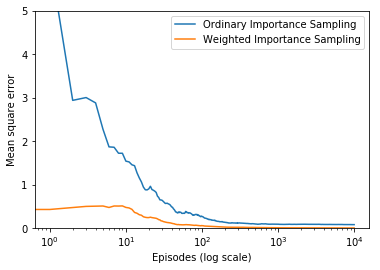

In [6]:
plot_5_3()